In [296]:
import xml.etree.ElementTree
import csv
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

In [297]:
%run utils/utilities.py

In [298]:
class_label_vn = [u"Cổ tay",u"Cổ chân",u"Bả vai",u"Xoay người",u"Xoay đầu gối",u"Đi bộ",u"Chạy",u"Đạp xe",u"Đánh răng",u"Rửa tay",u"Lau bàn",u"Nạo",u"Thái",u"Trộn",u"Lên cầu thang",u"Xuống cầu thang"]

In [299]:
DATASET_ROOT = './datasets/PTIT'
DATASET_NORM = DATASET_ROOT + '/normalized'
DATASET_TRAIN = DATASET_NORM + '/train'
DATASET_TEST = DATASET_NORM + '/test'
WINDONW_OVERLAP = 0.5
WINDOWN_OVERLAP_SIZE = WINDONW_OVERLAP * WINDOWN_SIZE
ANNO_FILE = 'anno.eaf'
WAX3_FILE = 'wax3.csv'
GEARS2_FILE = 'gears2.csv'

In [300]:
train_window_cnt = {}
test_window_cnt = {}
total_window = 0

In [301]:
def getAnno(anno_path):
    timestamp = {}
    annotation = []
    time_range = []
    root_ele = xml.etree.ElementTree.parse(anno_path).getroot()
    for time_slot in root_ele.iter('TIME_SLOT'):
        att = time_slot.attrib
        timestamp[att['TIME_SLOT_ID']]  = att['TIME_VALUE']
    for anno in root_ele.find('TIER').iter('ANNOTATION'):
        alig_anno = anno.find('ALIGNABLE_ANNOTATION')
        anno_text = alig_anno.find('ANNOTATION_VALUE').text.strip()
        if anno_text not in class_label:
            continue
        startTs = timestamp[alig_anno.attrib['TIME_SLOT_REF1']]
        endTs = timestamp[alig_anno.attrib['TIME_SLOT_REF2']]
#         annotation[anno_text] = {'start': startTs, 'end': endTs}
        annotation.append(anno_text)
        time_range.append({'start': int(startTs), 'end': int(endTs)})
    return annotation, time_range

def getMilisecond(s):
    try:
        hours, minutes, seconds = (["0", "0"] + s.split(":"))[-3:]
        hours = int(hours)
        minutes = int(minutes)
        seconds = float(seconds)
        miliseconds = int(3600000 * hours + 60000 * minutes + 1000 * seconds)
        return miliseconds
    except:
#         print "format exception " + s
        return 0

def getTotalWindowSize(len):
    total_size = (len // WINDOWN_SIZE) * 2 - 1 + (len % WINDOWN_SIZE) // WINDOWN_OVERLAP_SIZE
    return int(total_size)

In [302]:
def exportData(dir_path, target_path, is_training=True):
    global total_window
    anno_file = dir_path + '/' + ANNO_FILE
    sensor_data_path = target_path + '/sensor'
    x_watch_acc_file = sensor_data_path + '/x_watch_acc.txt'
    y_watch_acc_file = sensor_data_path + '/y_watch_acc.txt'
    z_watch_acc_file = sensor_data_path + '/z_watch_acc.txt'
    x_watch_gyr_file = sensor_data_path + '/x_watch_gyr.txt'
    y_watch_gyr_file = sensor_data_path + '/y_watch_gyr.txt'
    z_watch_gyr_file = sensor_data_path + '/z_watch_gyr.txt'
    x_sensor_acc_file = sensor_data_path + '/x_sensor_acc.txt'
    y_sensor_acc_file = sensor_data_path + '/y_sensor_acc.txt'
    z_sensor_acc_file = sensor_data_path + '/z_sensor_acc.txt'
    class_file = target_path + '/class.txt'
    annotation, time_range = getAnno(anno_file)
    num_anno = len(annotation)
    gears2_data = [[] for anno in annotation];
    wax3_data = [[] for anno in annotation];
    start_annotation = 0
    wax3_file = dir_path + '/' + WAX3_FILE
    gears2_file = dir_path + '/' + GEARS2_FILE
    with open(gears2_file, 'r') as gears2_csv, open(wax3_file, 'r') as wax3_csv:
        gears2_csv_reader = csv.reader(gears2_csv, delimiter=',')
        wax3_csv_reader = csv.reader(wax3_csv, delimiter=',')
        for row in gears2_csv_reader:
            ts = getMilisecond(row[0].strip())
            for i in range(num_anno):
                if ts >= time_range[i]['start'] and ts < time_range[i]['end']:
                    x_acc = float(row[1].strip())
                    y_acc = float(row[2].strip())
                    z_acc = float(row[3].strip())
                    x_gyr = float(row[4].strip())
                    y_gyr = float(row[5].strip())
                    z_gyr = float(row[6].strip())
                    gears2_data[i].append([ts, x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
                    
        for row in wax3_csv_reader:
            ts = getMilisecond(row[0].strip())
            for i in range(num_anno):
                if ts >= time_range[i]['start'] and ts < time_range[i]['end']:
                    x_acc = float(row[1].strip())
                    y_acc = float(row[2].strip())
                    z_acc = float(row[3].strip())
                    wax3_data[i].append([ts, x_acc, y_acc, z_acc])
         
    for i in range(num_anno):
        num_windows = getTotalWindowSize(len(gears2_data[i]))
        startWindow = 0
#         print num_windows
        for j in range(num_windows):
            windowSliced = gears2_data[i][startWindow:startWindow+WINDOWN_SIZE]
            if(len(windowSliced) < WINDOWN_SIZE):
                break
            startWindow += WINDOWN_SIZE
            startTs = windowSliced[0][0]
            endTs = windowSliced[WINDOWN_SIZE - 1][0]
            equivWax3Data = []
            # get data from wax3 and group with gears2
            for k in range(len(wax3_data[i])):
                wax3Ts = wax3_data[i][k][0]
                if(wax3Ts > endTs):
                    break
                if wax3Ts >= startTs and wax3Ts <= endTs:
                    equivWax3Data.append(wax3_data[i][k])
            zero_arr = [0 for zit in range(WINDOWN_SIZE)]
            while len(equivWax3Data) < WINDOWN_SIZE:
                equivWax3Data.append(zero_arr);
            equivWax3Data = equivWax3Data[0:WINDOWN_SIZE]
#             print (startTs, endTs, len(windowSliced), len(equivWax3Data))
            #export windows to file
            x_watch_acc = y_watch_acc = z_watch_acc = "";
            x_watch_gyr = y_watch_gyr = z_watch_gyr = "";
            x_sensor_acc = y_sensor_acc = z_sensor_acc = "";
#             if len(windowSliced) > 150 or len(equivWax3Data) > 150:
#                 print(i, j, len(windowSliced), len(equivWax3Data))
            for k in range(WINDOWN_SIZE):
                x_watch_acc = x_watch_acc + " " + str(windowSliced[k][1])
                y_watch_acc = y_watch_acc + " " + str(windowSliced[k][2])
                z_watch_acc = z_watch_acc + " " + str(windowSliced[k][3])
                
                x_watch_gyr = x_watch_gyr + " " + str(windowSliced[k][4])
                y_watch_gyr = y_watch_gyr + " " + str(windowSliced[k][5])
                z_watch_gyr = z_watch_gyr + " " + str(windowSliced[k][6])
                
                x_sensor_acc = x_sensor_acc + " " + str(equivWax3Data[k][1])
                y_sensor_acc = y_sensor_acc + " " + str(equivWax3Data[k][2])
                z_sensor_acc = z_sensor_acc + " " + str(equivWax3Data[k][3])
                

            with open(x_watch_acc_file, "a") as fw:
                fw.write(x_watch_acc + "\n")
            with open(y_watch_acc_file, "a") as fw:
                fw.write(y_watch_acc + "\n")
            with open(z_watch_acc_file, "a") as fw:
                fw.write(z_watch_acc + "\n")
                
            with open(x_watch_gyr_file, "a") as fw:
                fw.write(x_watch_gyr + "\n")
            with open(y_watch_gyr_file, "a") as fw:
                fw.write(y_watch_gyr + "\n")
            with open(z_watch_gyr_file, "a") as fw:
                fw.write(z_watch_gyr + "\n")
                
            with open(x_sensor_acc_file, "a") as fw:
                fw.write(x_sensor_acc + "\n")
            with open(y_sensor_acc_file, "a") as fw:
                fw.write(y_sensor_acc + "\n")
            with open(z_sensor_acc_file, "a") as fw:
                fw.write(z_sensor_acc + "\n")
            with open(class_file, "a") as fw:
                fw.write(str(class_label_int[annotation[i]]) + "\n")
        train_window_cnt[class_label_vn[int(class_label_int[annotation[i]])]]+=num_windows
        total_window+=num_windows;
#     return wax3_data
        
# exportData('./datasets/PTIT/001/in/', DATASET_TRAIN)

In [303]:
def prepareTrainTestFile(trainDir, testDir, name="default"):
    for dirPath in trainDir:
        print dirPath
        exportData(DATASET_ROOT + '/' + dirPath + '/in', DATASET_TRAIN, True)
        exportData(DATASET_ROOT + '/' + dirPath + '/out', DATASET_TRAIN, True)
    for dir in testDir:
        print dir
        exportData(DATASET_ROOT + '/' + dirPath + '/in', DATASET_TEST, False)
        exportData(DATASET_ROOT + '/' + dirPath + '/out', DATASET_TEST, False)

In [304]:
def prepareTempTrainTestFormat():
    global train_window_cnt
    global test_window_cnt
    global total_train_window
    trainDir = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]
    testDir = ["011","013", "014"]
    total_train_window = 0
    train_window_cnt = dict.fromkeys(class_label_vn, 0)
    test_window_cnt = dict.fromkeys(class_label_vn, 0)
    prepareTrainTestFile(trainDir, testDir)
    print ("training window count ", train_window_cnt)
    print ("test window count ", test_window_cnt)

In [305]:
def randomTrainFile():
    records = None
    random_dir = DATASET_NORM + "_random/train"
    files = [DATASET_TRAIN + "/" + "class.txt"]
    files_random  = [random_dir + "/" + "class.txt"]
    for channel in CHANNEL_LIST:
        filePath = DATASET_TRAIN + "/sensor/" + channel + ".txt"
        files.append(filePath)
        files_random.append(random_dir + "/sensor/" + channel + ".txt")
    for file in files:
        print "read file " + file
        with open(file) as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines]
            if records == None:
                print "create records"
                records = [[] for _ in range(len(lines))]
            for idx, line in enumerate(lines):
                records[idx].append(line)
#                 print (idx, line, records[idx][0])
#             return
    print "record len %d" % len(records)
    shuffle(records)
    total10 = total0 = 0;
    for file_idx, file in enumerate(files_random):
        print "write file " + file
        with open(file, "a") as wf:
            for record in records:
#                 print record[file_idx]
                wf.write(record[file_idx] + "\n")
    print(total0, total10)

In [306]:
!rm -rf datasets/PTIT/normalized*
#!mkdir -p datasets/PTIT/normalized/{train,test}/sensor
!mkdir -p datasets/PTIT/normalized/train/sensor
!mkdir -p datasets/PTIT/normalized/test/sensor
!mkdir -p datasets/PTIT/normalized_random/train/sensor
!mkdir -p datasets/PTIT/normalized_random/test/sensor
prepareTempTrainTestFormat()
randomTrainFile()

001
002
003
004
005
006
007
008
009
010
011
013
014
('training window count ', {u'Lau b\xe0n': 525, u'Ch\u1ea1y': 961, u'L\xean c\u1ea7u thang': 532, u'\u0110\u1ea1p xe': 768, u'Xu\u1ed1ng c\u1ea7u thang': 444, u'N\u1ea1o': 924, u'\u0110\xe1nh r\u0103ng': 483, u'Tr\u1ed9n': 908, u'C\u1ed5 tay': 465, u'\u0110i b\u1ed9': 1094, u'R\u1eeda tay': 535, u'Xoay ng\u01b0\u1eddi': 439, u'B\u1ea3 vai': 449, u'Th\xe1i': 934, u'C\u1ed5 ch\xe2n': 496, u'Xoay \u0111\u1ea7u g\u1ed1i': 421})
('test window count ', {u'Lau b\xe0n': 0, u'Ch\u1ea1y': 0, u'L\xean c\u1ea7u thang': 0, u'\u0110\u1ea1p xe': 0, u'Xu\u1ed1ng c\u1ea7u thang': 0, u'N\u1ea1o': 0, u'\u0110\xe1nh r\u0103ng': 0, u'Tr\u1ed9n': 0, u'C\u1ed5 tay': 0, u'\u0110i b\u1ed9': 0, u'R\u1eeda tay': 0, u'Xoay ng\u01b0\u1eddi': 0, u'B\u1ea3 vai': 0, u'Th\xe1i': 0, u'C\u1ed5 ch\xe2n': 0, u'Xoay \u0111\u1ea7u g\u1ed1i': 0})
read file ./datasets/PTIT/normalized/train/class.txt
create records
read file ./datasets/PTIT/normalized/train/sensor/x_sensor_ac

[u'a', u'h', u'\xea', u'\u1ea1', u'u', u'\u1ea1', u'\xe1', u'r', u'\u1ed5', u'i', u'\u1eed', u'o', u'\u1ea3', u'h', u'\u1ed5', u'o']


([<matplotlib.axis.XTick at 0x7f30dfd963d0>,
 <a list of 16 Text xticklabel objects>)

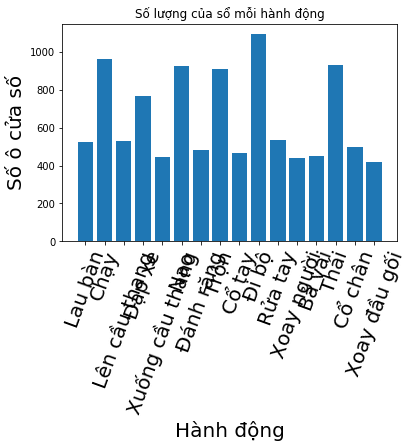

In [307]:
fig, ax = plt.subplots() 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
newlist = train_window_cnt
print [val[1] for val in newlist]
ax.set_title(u"Số lượng của sổ mỗi hành động")
ax.set_xlabel(u"Hành động", fontsize=20)
ax.set_ylabel(u"Số ô cửa số", fontsize=20)
plt.bar(range(len(newlist)), list(newlist.values()), align='center')
plt.xticks(range(len(newlist)), list(newlist.keys()), rotation=70, fontsize=20)

# plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
# plt.xticks(range(len(top20)), [val[0] for val in top20])
# plt.xticks(rotation=70)
# plt.show()

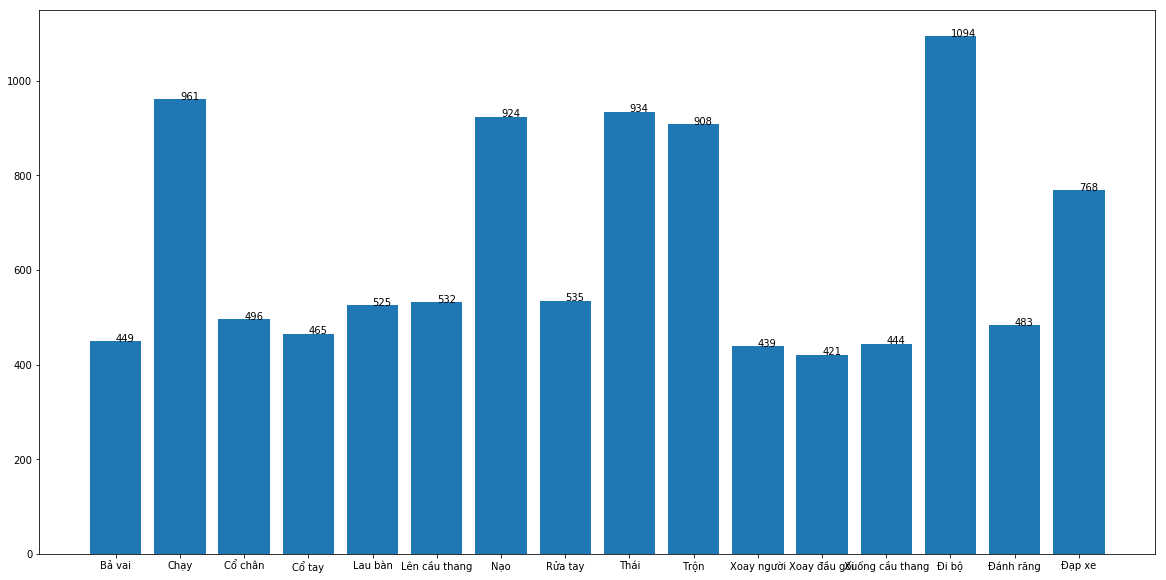

In [308]:
x = list(train_window_cnt.keys())
y = list(train_window_cnt.values())
plt.bar(x, y)
for a,b in zip(x, y):
    plt.text(a, b, str(b))
plt.show()

In [309]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
print confusion_matrix(y_true, y_pred)
precision_recall_fscore_support(y_true, y_pred, average=None,  labels=['pig', 'dog', 'cat'])

[[2 0 0]
 [1 0 1]
 [0 2 0]]


(array([ 0.        ,  0.        ,  0.66666667]),
 array([ 0.,  0.,  1.]),
 array([ 0. ,  0. ,  0.8]),
 array([2, 2, 2]))

In [310]:
listone = [1,2,3]
listtwo = [4,5,6]
mergedlist = []
mergedlist.extend(listone)
mergedlist.extend(listtwo)
print mergedlist


[1, 2, 3, 4, 5, 6]
